In [1]:
import os
import torch
from torch import nn, optim
from torch.autograd import Variable
from torch.utils.data import DataLoader
from torchvision import transforms
import torchvision
import torch.nn.functional as F
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np


In [2]:
# Random seed 
torch.manual_seed(10001)

# Read the data and convert it into tensor
train = pd.read_csv('N:/Complex_system/data/logistic_map/logistic_mapr3.csv')


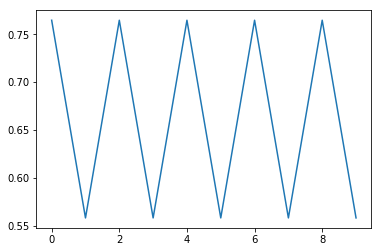

In [3]:
plt.plot(train.values[-10:])
plt.show()

### Convert data values into tensor

In [4]:

train_tensor = torch.tensor(train.values)
train_tensor.shape

torch.Size([10000, 1])

### Scale the input: Haven't plotted the result; Model shows no learning for scaled input tensors

In [5]:
# from sklearn.preprocessing import MinMaxScaler

# x_scaler = MinMaxScaler()

# x_train_scaled = x_scaler.fit_transform(train_tensor[:99000])

In [6]:
# print(x_train_scaled,x_train_scaled.shape)

### Load Data

In [7]:
# Batch size
bs =512

# train_data_loader = torch.utils.data.DataLoader(x_train_scaled, batch_size=bs, shuffle=False)
train_data_loader = torch.utils.data.DataLoader(train_tensor, batch_size=bs,drop_last=True, shuffle=False)

# NOTE: Shuffle is set to false to preserve the sequence in data

#### Prechecks on data loader

In [8]:
batch = list(train_data_loader)[0]  # [bs,inp_dim]
print(batch.shape)


torch.Size([512, 1])


### VAE model

##### Auto-Encoding Variational Bayes; Diederik P Kingma, Max Welling: https://arxiv.org/pdf/1312.6114.pdf

In [9]:
class VAE(nn.Module):
    def __init__(self, in_dim = 1, hidden_dim = 512, n_layers = 2, out_dim =1 ,z_dim= 12):
        
        super(VAE, self).__init__()
        
        # HYPERPARAMETERS
        self.n_layers = n_layers
        self.hidden_dim = hidden_dim
        self.z_dim = z_dim
        
        # ACTIVATION FUNCTIONS
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()
        
        # ENCODER
        self.encoder_lstm = nn.LSTM(in_dim, hidden_dim, n_layers, batch_first=True)                                  
#         self.encoder_output = nn.Linear(hidden_dim, z_dim*2)
        self.encoder_output = nn.Linear(hidden_dim, hidden_dim)
        
        # DECODER
#         self.decoder_lstm = nn.LSTM(z_dim, hidden_dim, n_layers, batch_first=True) 
        self.decoder_lstm = nn.LSTM(hidden_dim, hidden_dim, n_layers, batch_first=True)
        self.decoder_output = nn.Linear(hidden_dim, out_dim)
        
     
    # LATENT SAMPLER
    def reparameterize(self, mu, logvar):
        
        std = logvar.mul(0.5).exp_()
        esp = Variable(torch.randn(*mu.size())).cuda()
        z = mu + std * esp
        return z
                                          
    def forward(self, x):
        
        # Encoder
        enc_hidden = self._init_hidden()   
        enc,_ = self.encoder_lstm(x,enc_hidden)
        enc = self.relu(enc)

        # Reparameterize
        z_var = self.encoder_output(enc)
        mu,logvar = torch.chunk(z_var, 2, dim=2)     
        z = self.reparameterize(mu, logvar)
        
        # Decoder
        dec_hidden = self._init_hidden()
#         dec,_ = self.decoder_lstm(z,dec_hidden)
        dec,_ = self.decoder_lstm(enc,dec_hidden)
        dec = self.relu(dec)
        dec = self.decoder_output(dec)
        
        return dec, mu, logvar
    
    
    def _init_hidden(self):
        return (torch.zeros(self.n_layers, bs, self.hidden_dim).cuda(), torch.zeros(self.n_layers, bs, self.hidden_dim).cuda())
        

In [10]:
vae = VAE()
if torch.cuda.is_available():
    vae.cuda()
vae

VAE(
  (relu): ReLU()
  (sigmoid): Sigmoid()
  (encoder_lstm): LSTM(1, 512, num_layers=2, batch_first=True)
  (encoder_output): Linear(in_features=512, out_features=512, bias=True)
  (decoder_lstm): LSTM(512, 512, num_layers=2, batch_first=True)
  (decoder_output): Linear(in_features=512, out_features=1, bias=True)
)

In [11]:
optimizer = torch.optim.Adam(vae.parameters(), lr=1e-3)

In [12]:
def loss_fn(recon_x, x, mu, logvar,eps):
    
    # When sigmoid output, for time series, linear function is must

    RMSE = torch.sqrt(torch.mean((recon_x-x)**2))
    
#     KLD = -0.5 * torch.sum(1 + logvar - mu**2 -  logvar.exp()) + eps

    return RMSE 

In [13]:
epochs = 10
eps = torch.Tensor([1e-10]).cuda()
x_pred = []
for epoch in range(epochs):
    for idx, x in enumerate(train_data_loader):
         
        x = x.unsqueeze(1).float().cuda()  # [bs,1,inp_dim]
        recon_x, mu, logvar = vae(x)   
        loss = loss_fn(recon_x, x, mu, logvar,eps)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
#         print(KLD)
#         print(RMSE)
        if epoch == epochs-1:
            x_pred.extend(recon_x.cpu().squeeze())
        if idx%100 == 0:
            print("Epoch[{}/{}] Loss: {:.3f}".format(epoch+1, epochs, loss.item()/bs))
            

Epoch[1/10] Loss: 0.001
Epoch[2/10] Loss: 0.000
Epoch[3/10] Loss: 0.000
Epoch[4/10] Loss: 0.000
Epoch[5/10] Loss: 0.000
Epoch[6/10] Loss: 0.000
Epoch[7/10] Loss: 0.000
Epoch[8/10] Loss: 0.000
Epoch[9/10] Loss: 0.000
Epoch[10/10] Loss: 0.000


In [14]:
checkpoint = {'model': VAE(),
          'state_dict': vae.state_dict(),
          'optimizer' : optimizer.state_dict()}

torch.save(checkpoint, 'checkpoint_lstm_logistic_rmse.pth')

C:\Users\saran\Anaconda3\envs\tensor\lib\site-packages\torch\serialization.py:251: UserWarning: Couldn't retrieve source code for container of type VAE. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


In [15]:
np.asarray(x_pred).shape

(9728,)

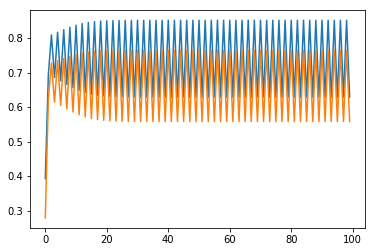

In [16]:
plt.plot(x_pred[:100])
plt.plot(train.values[:100])
plt.savefig('logistic_lstm_vae.png')
plt.show()